### 0. Import libraries and load data

In [12]:
import os
import sys
import json
import h5py
import random
import numpy as np

import matplotlib.pyplot as plt

import tensorflow as tf
import keras.utils as image
from keras.models import Model
from keras.callbacks import EarlyStopping
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D


FOLDER_PATH = "../data/"
DATABASE_PATH = "database/database_lite.json"
QUERY_PATH = "query/query_lite.json"
SIMILARITY_FILE_NAME = "london_lite_gt.h5"


In [13]:
# map
with open(FOLDER_PATH + DATABASE_PATH, "r") as f:
    m_idx = json.load(f)
    m_imgs = np.array(m_idx["im_paths"])
    m_loc = np.array(m_idx["loc"])

# query
with open(FOLDER_PATH + QUERY_PATH, "r") as f:
    q_idx = json.load(f)
    q_imgs = np.array(q_idx["im_paths"])
    q_loc = np.array(q_idx["loc"])
    
# loading the relevance judgements
with h5py.File(FOLDER_PATH + SIMILARITY_FILE_NAME, "r") as f:
    fovs = f["fov"][:]
    sim = f["sim"][:].astype(np.uint8)


### 1. Pre-process images

In [14]:
def get_image_shapes(image_paths):
    image_shapes = set()

    for image_path in image_paths:
        img = plt.imread(os.path.join(FOLDER_PATH + image_path))
        image_shapes.add(img.shape)
        
    return image_shapes


In [15]:
def get_smallest_image_size(m_imgs_shapes, q_imgs_shapes):
    smallest_shape = None
    smallest_size = sys.maxsize
    imgs_shapes = q_imgs_shapes.union(m_imgs_shapes)

    for img_shape in imgs_shapes:
        image_size = img_shape[0] * img_shape[1] * img_shape[2]

        if image_size <= smallest_size:
            smallest_size = image_size
            smallest_shape = img_shape
            
    new_even_dims = []

    for dim_index in range(len(smallest_shape) - 1):
        if smallest_shape[dim_index] % 2 == 1:
            new_even_dims.append(smallest_shape[dim_index] - 1)
        else:
            new_even_dims.append(smallest_shape[dim_index])

    smallest_shape_even = (new_even_dims[0], new_even_dims[1], smallest_shape[2])
    print(f"\nSmallest image shape with even sizes is: {smallest_shape_even}")

    return smallest_shape_even


In [16]:
m_imgs_shapes = get_image_shapes(m_imgs)
print(f"Shapes of database images:\n{m_imgs_shapes}")

q_imgs_shapes = get_image_shapes(q_imgs)
print(f"\nShapes of query images:\n{q_imgs_shapes}")

smallest_image_shape = get_smallest_image_size(m_imgs_shapes, q_imgs_shapes)


Shapes of database images:
{(256, 455, 3), (256, 341, 3), (256, 367, 3)}

Shapes of query images:
{(256, 341, 3), (256, 455, 3)}

Smallest image shape with even sizes is: (256, 340, 3)


In [17]:
def load_images(image_paths, image_size):
    preprocessed_images = np.zeros(
        (len(image_paths), image_size[0], image_size[1], image_size[2])
    )

    for index, image_path in enumerate(image_paths):
        raw_img = image.load_img(FOLDER_PATH + image_path)
        resized_img = tf.image.resize(raw_img, (image_size[0], image_size[1]))
        scaled_img = resized_img / 255
        array_img = image.img_to_array(scaled_img).astype("float32")
        preprocessed_images[index] = array_img
        
    return preprocessed_images


In [18]:
database_images = load_images(m_imgs, smallest_image_shape)
print(f"Shape of database dataset: {database_images.shape}")

query_images = load_images(q_imgs, smallest_image_shape)
print(f"Shape of query dataset: {query_images.shape}")


Shape of database dataset: (1000, 256, 340, 3)
Shape of query dataset: (500, 256, 340, 3)


In [19]:
def display_reshaped_image(database_images, m_imgs, image_index):
    fig, ax = plt.subplots(2, 1)
    fig.tight_layout()

    ax[0].imshow(plt.imread(os.path.join(FOLDER_PATH + m_imgs[image_index])))
    ax[0].set_title("Original image")

    ax[1].imshow(database_images[image_index])
    ax[1].set_title("Resized image")

    plt.show()


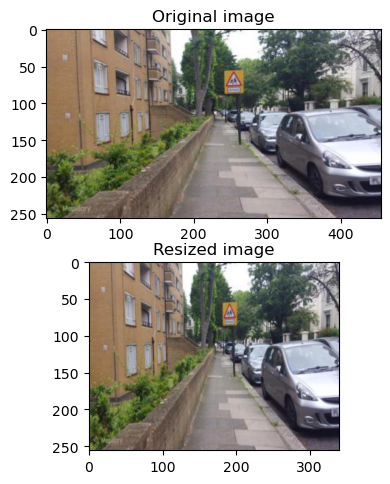

In [20]:
display_reshaped_image(database_images, m_imgs, image_index=6)


### 2. Build and train autoencoder

In [21]:
input_layer = Input(shape=smallest_image_shape)   
conv_2d_1 = Conv2D(16, (3, 3), activation='relu', padding='same', strides=2)(input_layer)
bootleneck = Conv2D(8, (3, 3), activation='relu', padding='same', strides=2)(conv_2d_1)

conv_2d_t_1 = Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same')(bootleneck)
conv_2d_t_2 = Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same')(conv_2d_t_1)
output_layer = Conv2D(3, kernel_size=(3, 3), activation='sigmoid', padding='same')(conv_2d_t_2)

autoencoder = Model(inputs=input_layer, outputs=output_layer)
encoder = Model(inputs=input_layer, outputs=bootleneck)

autoencoder.compile(loss='mean_squared_error', optimizer='adam')
autoencoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 340, 3)]     0         
                                                                 
 conv2d_3 (Conv2D)           (None, 128, 170, 16)      448       
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 85, 8)         1160      
                                                                 
 conv2d_transpose_2 (Conv2D  (None, 128, 170, 8)       584       
 Transpose)                                                      
                                                                 
 conv2d_transpose_3 (Conv2D  (None, 256, 340, 16)      1168      
 Transpose)                                                      
                                                                 
 conv2d_5 (Conv2D)           (None, 256, 340, 3)       435 

In [22]:
callback = EarlyStopping(monitor='val_loss', patience=3)
history = autoencoder.fit(database_images, database_images, epochs=10, batch_size=64, validation_split=0.1, shuffle=True, callbacks=[callback])

Epoch 1/10
15/15 [==============================] - 55s 3s/step - loss: 0.0632 - val_loss: 0.0777
Epoch 2/10
15/15 [==============================] - 49s 3s/step - loss: 0.0581 - val_loss: 0.0644
Epoch 3/10
15/15 [==============================] - 49s 3s/step - loss: 0.0475 - val_loss: 0.0443
Epoch 4/10
15/15 [==============================] - 49s 3s/step - loss: 0.0320 - val_loss: 0.0262
Epoch 5/10
15/15 [==============================] - 53s 4s/step - loss: 0.0176 - val_loss: 0.0143
Epoch 6/10
15/15 [==============================] - 50s 3s/step - loss: 0.0102 - val_loss: 0.0098
Epoch 7/10
15/15 [==============================] - 49s 3s/step - loss: 0.0076 - val_loss: 0.0086
Epoch 8/10
15/15 [==============================] - 50s 3s/step - loss: 0.0065 - val_loss: 0.0075
Epoch 9/10
15/15 [==============================] - 50s 3s/step - loss: 0.0059 - val_loss: 0.0068
Epoch 10/10
15/15 [==============================] - 50s 3s/step - loss: 0.0056 - val_loss: 0.0065


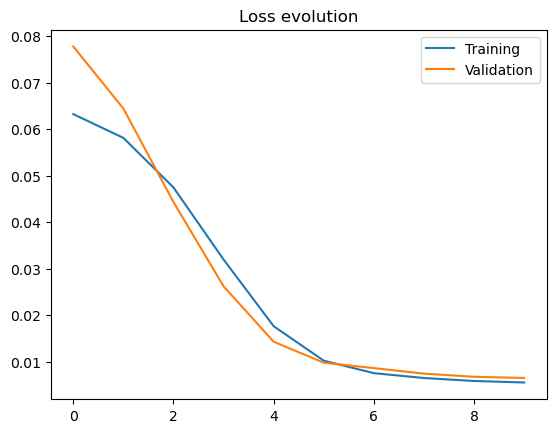

In [23]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])

plt.title("Loss evolution")
plt.legend(["Training", "Validation"])

In [24]:
# TODO: define a cross-validation function
# TODO: find the hyperparameters space
# TODO: optimize the model

### 3. Visualize reconstructed images

In [25]:
def display_reconstructed_images(autoencoder, database_images, query_images):
    fig, ax = plt.subplots(3, 4)
    fig.set_size_inches(18, 9)

    for i in range(3):
        database_image_index = random.randint(0, len(database_images) - 1)
        original_databse_image = database_images[database_image_index]
        reconstructed_database_image = autoencoder.predict(np.array([original_databse_image]), verbose=0)[0]

        ax[i][0].imshow(original_databse_image)
        ax[i][1].imshow(reconstructed_database_image)

        if i == 0:
            ax[i][0].set_title("Original\ndatabase")
            ax[i][1].set_title("Reconstructed\ndatabase")

        query_image_index = random.randint(0, len(query_images) - 1)
        original_query_image = query_images[query_image_index]
        reconstructed_query_image = autoencoder.predict(np.array([original_query_image]), verbose=0)[0]

        ax[i][2].imshow(original_query_image)
        ax[i][3].imshow(reconstructed_query_image)

        if i == 0:
            ax[i][2].set_title("Original\nquery")
            ax[i][3].set_title("Reconstructed\nquery")

    plt.show()

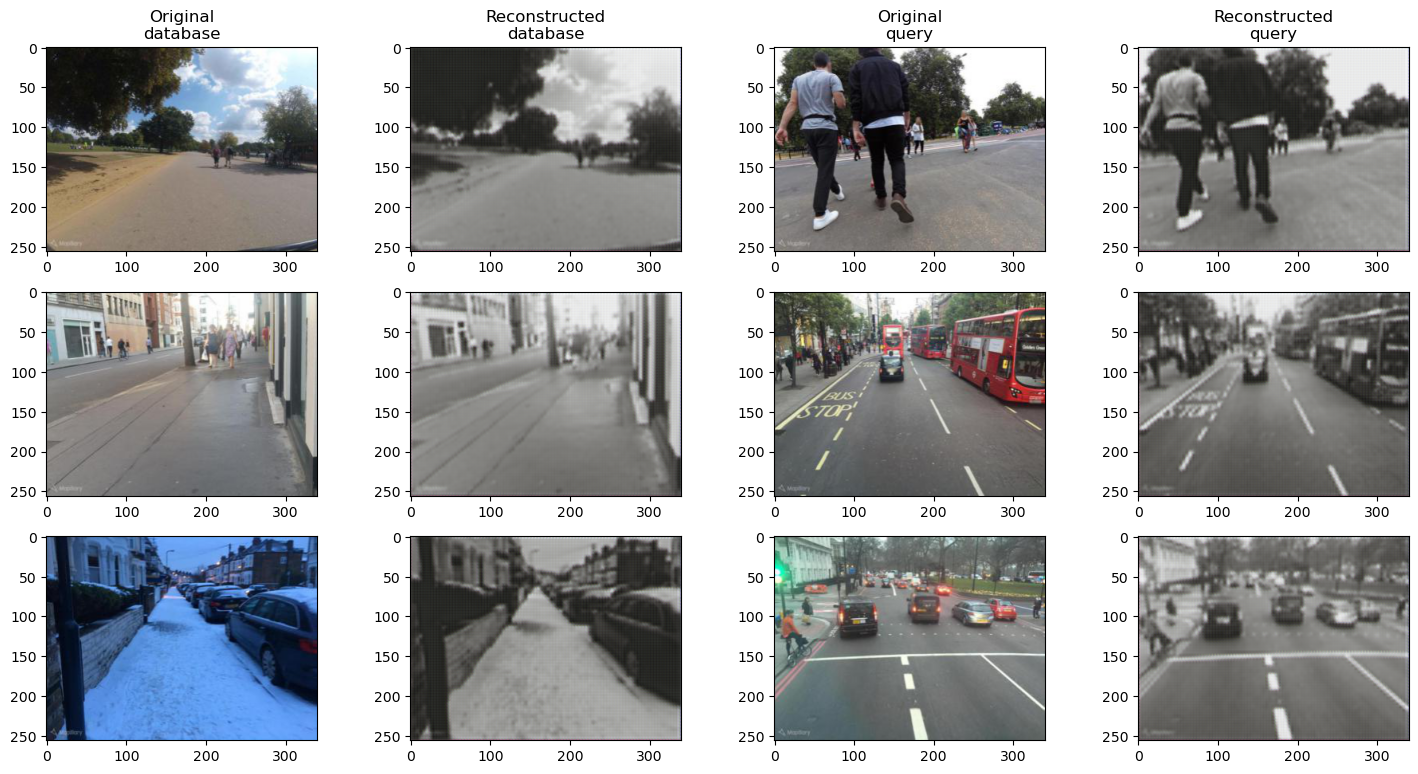

In [26]:
display_reconstructed_images(autoencoder, database_images, query_images)

### 4. Encode images and store encodings

In [27]:
def store_encoded_images(encoder, images, dataset_path):
    dataset_name = dataset_path.split("/")[-1][:-5]

    images_no = images.shape[0]
    encoded_images = encoder.predict(images).reshape(images_no, -1)

    print(f"Storing encoded {dataset_name} images. Dataset size: {encoded_images.shape}\n")

    with open(FOLDER_PATH + dataset_path[:-5] + "_encoded.npy", "wb") as f:
        np.save(f, encoded_images)

In [28]:
store_encoded_images(encoder, database_images, DATABASE_PATH)
store_encoded_images(encoder, query_images, QUERY_PATH)

32/32 [==============================] - 1s 41ms/step
Storing encoded database_lite images. Dataset size: (1000, 43520)

16/16 [==============================] - 1s 39ms/step
Storing encoded query_lite images. Dataset size: (500, 43520)



### 5. Load encoded images

In [29]:
def load_encoded_images(dataset_path):
    dataset_name = dataset_path.split("/")[-1][:-5]

    print(f"Loading encoded {dataset_name} images")

    with open(FOLDER_PATH + dataset_path[:-5] + "_encoded.npy", "rb") as f:
        encoded_images = np.load(f)  

    return encoded_images

In [30]:
encoded_database_images = load_encoded_images(DATABASE_PATH)
encoded_query_images = load_encoded_images(QUERY_PATH)

Loading encoded database_lite images


Loading encoded query_lite images
